In [442]:
import os
import time
import sys
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestCentroid, kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree, cKDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from concorde.tsp import TSPSolver
from math import sqrt, ceil, inf, floor

In [443]:
root_dir = os.getcwd()
tsp_dir = os.path.join(root_dir, "../tsplib")
concorde_dir = os.path.join(root_dir, "../pyconcorde/concorde")

In [444]:
sys.path.insert(0, root_dir)
sys.path.insert(0, tsp_dir)
#sys.path.insert(0, concorde_dir)

In [445]:
num_samples = 10000

In [446]:
def gen_tsp_data():
    ## Load a tsp library and Create a dictionary "tsp_database" of Name-X/Y coordinates.

    tsp_database = {}
    cities = os.listdir(tsp_dir)
    
    for city in cities:
        if city.endswith(".tsp"):
            with open(tsp_dir + '/' + city, 'r') as infile:
                lines = infile.readlines()
                for i in range(0, len(lines)):
                    line = lines[i]
                    if "DIMENSION" in line:
                        Dimension = line.strip().split(':')[1]
                        if not Dimension.isdigit():
                            continue
                    if "EDGE_WEIGHT_TYPE" in line:
                        EdgeWeightType = line.strip().split()[1]
                        if EdgeWeightType != "EUC_2D":
                            continue
                    if "NODE_COORD_SECTION" in line:
                        x_y = None
                        nodelist_x = []
                        nodelist_y = []
        
                        for j in range (1, int(Dimension)):
                            x_y = lines[i+1].strip().split()[1:]
    #                        print(x_y)
    #                        import pdb; pdb.set_trace()
                            x = x_y[0]
                            y = x_y[1]
                            nodelist_x.append(float(x))
                            nodelist_y.append(float(y))
                            i+=1
                        tsp_database.update({city[:-4]:[nodelist_x, nodelist_y]})
    return tsp_database    

In [447]:
tsp_database = gen_tsp_data()
problem_list = tsp_database.keys()
problem_list

dict_keys(['pcb442', 'd15112', 'pla7397', 'd18512', 'd2103', 'fl1400', 'pr107', 'berlin52', 'fl3795', 'pcb3038', 'gr666', 'fnl4461', 'gil262', 'kroB200', 'kroE100', 'pr2392', 'lin318', 'pla85900', 'usa13509', 'brd14051', 'pla33810', 'pr152', 'pr226', 'pr1002', 'u2152', 'eil76', 'rl5934', 'bier127', 'rl5915', 'u2319', 'rat783', 'rl11849', 'rat575', 'kroA100', 'eil101'])

In [448]:
cluster_dict = {
    "berlin52": [9],
    "eil76": [9],
    "eil101": [21,3],
    "kroE100": [14,2],
    "kroB200": [33,5],
    "gil262": [41,4],
    "lin318": [56,6],
    "pcb442": [79,10],
    "rat575": [73,9],
    "gr666": [335,52,7],
    "rat783": [113,14,2],
    "pr1002": [161,21,2],
    "d2103": [288,42,6],
    "u2152": [365,50,6],
    "pr2392": [416,55,6],
    "pcb3038": [487,75,8],
    "fnl4461": [773,125,16,2],
    "rl5915": [980,139,17,2],
    "rl5934": [1237,196,29,4],
    "rl11849": [2341,375,61,7],
    "pla33810": [6446,1257,192,28,3]
    }

Problem : pr1002


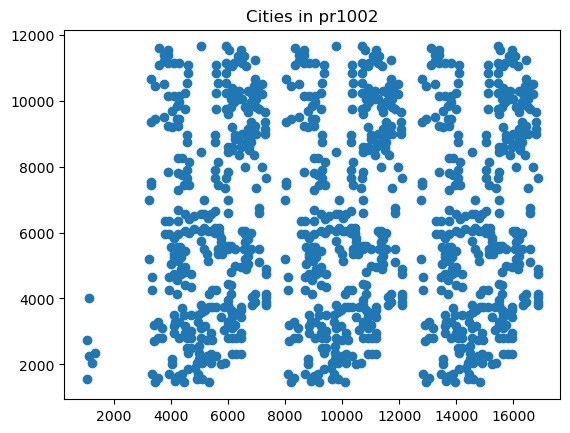

In [449]:
import pyproj as p

clusters_dict = {"rat783":[113,14,2]}

x = "pr1002"
n_clusters = cluster_dict[x]
#n_clusters = [416,55,6]
#x = "pla33810"
## Connectivty and Complete linkage
#n_clusters = [6600,1417,233,39,8,1]
#x = "pla85900"
coord_geo = False
if coord_geo == True:
     crs_wgs = p.Proj(init='epsg:4326')
     crs_bng = p.Proj(init = 'epsg:27700')
    
     tsp_database[x][0],tsp_database[x][1]  = p.transform(crs_wgs, crs_bng, tsp_database[x][1], tsp_database[x][0])
# for x in tsp_database:
print("Problem : " + x)
#    print(tsp_database[x])
X_coord = np.array(tsp_database[x][0])
Y_coord = np.array(tsp_database[x][1])
X_Y = np.array(list(zip(X_coord,Y_coord))).reshape(len(X_coord),2)
plt.plot()
plt.title('Cities in ' + x)
plt.scatter(X_coord, Y_coord)
plt.show()


lt.plot()<br>
lt.title('Cities in ' + x)<br>
lt.scatter(X_coord, Y_coord)<br>
lt.show()

In [450]:
from numpy import inf

X_Y[X_Y == inf] = 0


In [451]:
def get_clustered_cities(num_clust, labels_array):
    return np.where(labels_array == num_clust)

In [452]:
def plot_sys2_cities(sys2_cities):
    for k in K:
        plt.scatter(sys2_cities[k][:,0], sys2_cities[k][:,1])
        plt.show()

In [453]:

import time   
from k_means_constrained import KMeansConstrained

X_Y=[X_Y]
KM_labels = []
i = 0

cluster_size_min = 3
cluster_size_max = 12

Contrained = False
## 0: K-means++ // 1: Agglomerative
Clustering_Methods = 1

hierarchies = []

CEs = []
clf = NearestCentroid()
SEARCH = False
if SEARCH:
    n_clusters = floor(len(X_Y[i])/cluster_size_max)
    #n_clusters = 10000
    while True:
        if Contrained:
            KMC = KMeansConstrained(
                n_clusters = n_clusters,
                size_min = cluster_size_min,
                size_max = cluster_size_max,
                random_state = 0)
            y_KMC = KMC.fit_predict(X_Y[i])
            centers = KMC.cluster_centers_
        elif Clustering_Methods == 0:
            kmeanModel = KMeans(n_clusters, init='k-means++', n_init=10).fit(X_Y[i])
            y_KMC = kmeanModel.labels_
            centers = kmeanModel.cluster_centers_
        else:
            #knn_graph = kneighbors_graph(X_Y[i], n_clusters, include_self=False)
            #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', connectivity= knn_graph, linkage='complete').fit(X_Y[i])
            #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', connectivity= knn_graph, linkage='ward').fit(X_Y[i])
            #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', linkage='complete').fit(X_Y[i])
            AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', linkage='ward').fit(X_Y[i])
            y_KMC = AggloModel.labels_
            clf.fit(X_Y[i], y_KMC)
            centers = clf.centroids_
        ICC = 0
        ICS = 0
        n_max = 0
        n_min = inf
        for c in range(len(centers)):
            center = centers[c]
            cities = np.where(y_KMC==c)[0]
            if len(cities) < n_min:
                n_min = len(cities)
            if len(cities) > n_max:
                n_max = len(cities)
            for city in cities:
                ICC += sqrt((X_Y[i][city][0]-center[0])**2+(X_Y[i][city][1]-center[1])**2)
            if len(cities) >1 :
                ICS += ICC/len(cities)
            ICC = 0
            #for center2 in centers:
            #    ICS += sqrt((center[0]-center2[0])**2+(center[1]-center2[1])**2)
        #CE = ICC/ICS
        CE = ICS/len(centers)
        CEs.append(CE)
        #Score = silhouette_score(X_Y[i], y_KMC)
        if len(CEs) > 10:
            MEAN = sum(CEs[-9:])/10
        else:
            MEAN = sum(CEs)/len(CEs)
        print(n_clusters, n_min, n_max, CE, MEAN)
        
        if (n_max < cluster_size_max+1):# and (n_clusters == 2 or MEAN*0.999 < CE):# and (MinScore*1.01 > Score):
            plt.plot(range(len(CEs)), CEs, 'r-')
            plt.show()
            colors = mpl.cm.tab20(range(20))
            c_labels = []
            for yy in y_KMC:
                c_labels.append(colors[yy%20])
            #plt.scatter(X_Y[i][:,0], X_Y[i][:,1], c=y_KMC, s=10, cmap='viridis')
            plt.scatter(X_Y[i][:,0], X_Y[i][:,1], c=c_labels, s=10)
            plt.scatter(centers[:,0], centers[:,1], c='black', s=50, alpha=0.5)
            plt.rcParams.update({'font.size':15})
            plt.show()
            
            KM_labels.append(y_KMC)
            X_Y.append(centers)
            hierarchies.append(len(centers))
            i += 1
            n_clusters = floor(len(X_Y[i])/cluster_size_max)
            if n_clusters < 2:
                n_clusters = 2
            if len(centers) < cluster_size_max+1:
                break
            CEs = []
        else:
            n_clusters += 1
else:
    Cluster_distribution = []
    for N_C in n_clusters:
        #knn_graph = kneighbors_graph(X_Y[i], n_clusters, include_self=False)
        #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', connectivity= knn_graph, linkage='complete').fit(X_Y[i])
        #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', connectivity= knn_graph, linkage='ward').fit(X_Y[i])
        #AggloModel = AgglomerativeClustering(n_clusters, metric='euclidean', linkage='complete').fit(X_Y[i])
        AggloModel = AgglomerativeClustering(N_C, metric='euclidean', linkage='ward').fit(X_Y[-1])
        y_KMC = AggloModel.labels_
        clf.fit(X_Y[-1], y_KMC)
        centers = clf.centroids_
        
        #####
        unique, counts = np.unique(y_KMC, return_counts=True)
        unique, counts = np.unique(counts, return_counts=True)
        Cluster_distribution.append(dict(zip(unique, counts)))
        #####
        
        KM_labels.append(y_KMC)
        X_Y.append(centers)
        hierarchies.append(len(centers))
        
    Cluster_distribution.append(dict(zip([hierarchies[-1]], [1])))
    print(hierarchies)
    print(Cluster_distribution)

[161, 21, 2]
[{1: 1, 2: 6, 3: 29, 4: 12, 5: 11, 6: 32, 7: 23, 8: 14, 9: 12, 10: 9, 11: 9, 12: 3}, {2: 1, 4: 1, 5: 1, 6: 6, 7: 1, 8: 1, 9: 4, 10: 3, 11: 3}, {9: 1, 12: 1}, {2: 1}]


In [454]:
## sys2_cities has [hierarchies where the sub-cluster belongs, Center X/Y coordinates of the sub-cluster, Cities X/Y coordinates in the sub-cluster]
## sys2_centers has [hierarchies where the sub-cluster belongs, Center X/Y coordinates of the sub-cluster]
## sys2_clusters has [hierarchies where the sub-cluster belongs, Cities X/Y coordinates in the sub-cluster]
sys2_centers = []
sys2_clusters = []

H = range(0,len(hierarchies))
for h in H:
    K = range(0,hierarchies[h])
    sys2_centers.append([])
    sys2_clusters.append([])
    colors = mpl.cm.tab20(range(20))
    for k in K:
        sys2_centers[h].append(X_Y[h+1][k])
        sys2_clusters[h].append(X_Y[h][get_clustered_cities(k, KM_labels[h])])
    largest_cluster_size = 0
    smallest_cluster_size = 100
    for k in K:
        if len(sys2_clusters[h][k]) > largest_cluster_size:
            largest_cluster_size = len(sys2_clusters[h][k])
        if len(sys2_clusters[h][k]) < smallest_cluster_size:
            smallest_cluster_size = len(sys2_clusters[h][k])
        if (len(sys2_clusters[h][k]) == 1):
            print("dirty cluster")
    print("The largest & smallest cluster size in Hierarchy ",h+1, ": ", largest_cluster_size, " & ", smallest_cluster_size)
## Add the topmost cluster
sys2_centers.append([])
sys2_clusters.append([])
sys2_centers[-1].append([0, 0])
sys2_clusters[-1].append(X_Y[-1])

dirty cluster
The largest & smallest cluster size in Hierarchy  1 :  12  &  1
The largest & smallest cluster size in Hierarchy  2 :  11  &  2
The largest & smallest cluster size in Hierarchy  3 :  12  &  9


In [455]:
def Fix_first_last_cities(sys2_centers, sys2_clusters, sol_route, Lowest_Hier):
    ## Find a pair of the closest cities, each of which is in a distinct cluster which will be sequentially visited.
    ## After finding, place each city of the pair in the end of the preceding cluster and the start of the following cluster.
    ## To avoid the city in the following cluster to be selected once again for the next search, the next search starts from Index 1.
    ## Refer to Page 25
    tree = cKDTree(sys2_centers)
    clust_id_list = []
    total_traveling_distance = 0
    
    for k in range(len(sol_route)-1):
        ## Finding a pair of cities from distinct sub-clusters having the shortest distance betweeen sub-clusters.
        clust_idx_curr = tree.query(sol_route[k])[1]
        clust_idx_next = tree.query(sol_route[k+1])[1]
        if k ==0:
            clust_id_list.append(clust_idx_curr)
        clust_id_list.append(clust_idx_next)
        
        curr_clust = sys2_clusters[clust_idx_curr]
        next_clust = sys2_clusters[clust_idx_next]
        tree_clust = cKDTree(next_clust)
        ## For the first cluster in a hierarchy, all cities in the cluster is included in the search.
        ## For clusters that include only one city, the city that has been chosen for the first city from the previous search 
        ## will be used for the search and chosen for the last city. The first and last city at the same time. 
        if k ==0 or len(curr_clust) == 1:
            search_init = 0
        ## Otherwise, the first city is excluded from the search, because it's already chosen for the first city.
        else:
            search_init = 1
        sht_dist = inf
        for inc in range(search_init, len(curr_clust)):
            val_sd, idx_sd = tree_clust.query(curr_clust[inc])
            if val_sd < sht_dist:
                sht_dist = val_sd
                sht_idx_curr = inc
                sht_idx_next = idx_sd
                
        ## Fix the first and the last cities according to the information found above, unless the clust has one city.
        if len(curr_clust) > 1:
            curr_clust[[-1, sht_idx_curr]] = curr_clust[[sht_idx_curr,-1]]
            sys2_clusters[clust_idx_curr] = curr_clust
        if len(next_clust) > 1:
            next_clust[[0, sht_idx_next]] = next_clust[[sht_idx_next,0]]
            sys2_clusters[clust_idx_next] = next_clust
        if Lowest_Hier:
            total_traveling_distance += sht_dist
            #print("Inter-cluster distance (clusters ", k, "-", k+1, "): ", sht_dist, " total distance: ", total_traveling_distance)
            
    return sys2_clusters, clust_id_list, total_traveling_distance

In [456]:
def skip_ising(Lowest_Hier, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, infile, outfile):
    print("Ising skipped!!")
    timet[-1].append(0)
    nMAC_array[-1].append(0)
    nRandFlip_array[-1].append(0)
    DIST = 0
    with open(infile,"r") as inF:
        lines = inF.readlines()
        outF = open(outfile,"w")
        
        for i in range(1, curr_clust_size+1):
            line = lines[i]
            outF.write(line)
            
            curr = line.strip().split()
            for j in range(len(curr)):
                curr[j] = float(curr[j])
            sol_route.append(curr)
            
            if Lowest_Hier:
                if (i == 1):
                    route_btw_clusters.append(curr)
                if (i == curr_clust_size):
                    route_btw_clusters.append(curr)
        if curr_clust_size == 1:
            DIST = 0
        else:
            for i in range(1, curr_clust_size):
                X1 = float(lines[i].strip().split()[0])
                Y1 = float(lines[i].strip().split()[1])
                X2 = float(lines[i+1].strip().split()[0])
                Y2 = float(lines[i+1].strip().split()[1])
                DIST += sqrt((X1-X2)**2+(Y1-Y2)**2)
        outF.write("\n")
        outF.write("dist ")
        outF.write(str(DIST))
        outF.write("\n")
        outF.write("n_MAC 0")
        outF.write("\n")
        outF.write("n_RandFlip 0")
        outF.write("\n")
        
        outF.close()
        inF.close()

        if Lowest_Hier:
            total_traveling_distance += DIST
    
    return total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array

In [457]:
def gen_sys2_sol(MAC_ising, benchmark, sys2_centers, sys2_clusters, SchPar):
    MAC_ising = True
    if MAC_ising:
        cpp_cmd = "./ising_mac"
    else :
        cpp_cmd = "./ising_RNG"
    os.system("rm -rf sys2clusters_" + str(benchmark))
    SYS2_CENTERS = sys2_centers
    SYS2_CLUSTERS = sys2_clusters
    
    timet =[]
    nMAC_array =[]
    nRandFlip_array = []
    sys2_labels = []
    colors = mpl.cm.tab20(range(20))
    sol_route = 0
    sol_route_ex = []
    
    ideal_latency = 0
    nMAC_hierarchies = []
    
    for h in range(0, n_hierarchies+1):
        print("Execute Ising Solver for Hierarchy ", n_hierarchies-h)
        sys2_centers = SYS2_CENTERS[n_hierarchies-h]
        sys2_clusters = SYS2_CLUSTERS[n_hierarchies-h]

        if h != 0:
            sys2_clusters, clust_id_list, total_traveling_distance = Fix_first_last_cities(sys2_centers, sys2_clusters, sol_route, h == n_hierarchies)
        else:
            clust_id_list = range(0, len(sys2_centers))
            
        sol_route_ex.append(sol_route)
        sol_route = []
        route_btw_clusters = []
        timet.append([])
        nMAC_array.append([])
        nRandFlip_array.append([])
        sys2_labels.append([])
        for k in range(len(clust_id_list)):
            curr_clust = sys2_clusters[clust_id_list[k]]
            curr_clust_size = len(curr_clust)
            for l in range(curr_clust_size):
                sys2_labels[h].append(colors[k%20])
            os.system("mkdir -p sys2clusters_" + str(benchmark))
            curr_filename = str(benchmark) + "_h" + str(n_hierarchies-h)  + "_c" + str(k) +".in"
            curr_logfile = str(benchmark) + "_h" + str(n_hierarchies-h)   + "_c" + str(k) +".out"
            inF = open("sys2clusters_" + str(benchmark) + "/" + curr_filename,"w")
            inF.write(str(curr_clust_size))
            inF.write("\n")
            for i in curr_clust:
                inF.write(str(i[0]) + " " + str(i[1]))
                inF.write("\n")
            inF.close()
            
            if h == 0:
                if curr_clust_size == 2:
                    total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, 0, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                    continue
            else:
                if k == 0 or k == len(clust_id_list)-1:
                    if curr_clust_size < 3:
                        total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                        continue
                else:
                    if curr_clust_size < 4:
                        total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array = skip_ising(h == n_hierarchies, total_traveling_distance, sol_route, route_btw_clusters, timet, nMAC_array, nRandFlip_array, curr_clust_size, "sys2clusters_" + str(benchmark) + "/" + curr_filename, "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
                        continue
            tic = time.perf_counter()
            ### when h>0, Problem_size to optimize = N-1 when k is 0 or -1, otherwise N-2
            if h == 0 :
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k0" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            elif k == len(clust_id_list)-1:
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k-1" + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            else :
                os.system(cpp_cmd+" -I "+str(SchPar[0])+" -c "+str(SchPar[1])+" -F "+str(SchPar[2])+" -D "+str(SchPar[3])+" -P "+str(SchPar[4])+" k" + str(k+1) + " sys2clusters_" + str(benchmark) + "/" + curr_filename + " >> " + "sys2clusters_" + str(benchmark) + "/" + curr_logfile)
            toc = time.perf_counter()
            timet[-1].append(toc-tic)
            
            dist_array =[]
            with open("sys2clusters_" + str(benchmark) + "/" + curr_logfile,"r") as outFile:
                lines = outFile.readlines()
                for i in range(0,len(lines)):
                    line = lines[i]
                    if "dist" in line:
                        dist_array.append(line.strip().split()[1])
                        continue
                    if "n_MAC" in line:
                        nMAC_array[-1].append(int(line.strip().split()[1]))
                        continue
                    if "n_RandFlip" in line:
                        nRandFlip_array[-1].append(int(line.strip().split()[1]))
                        continue
                dist = min(dist_array)
                ####################################
                ####################################
                if h == n_hierarchies:
                    total_traveling_distance += float(dist)
                    print("hierarchy: ", h, " cluster: ", k, " distance within the cluster: ", float(dist), " total distance: ", total_traveling_distance)
                ####################################
                ####################################
                for i in range(0, curr_clust_size):
                    line = lines[i]
                    curr = line.strip().split()
                    for j in range(len(curr)):
                        curr[j] = float(curr[j])
                    sol_route.append(curr)
                
                    if h == n_hierarchies:
                        if (i == 0) or (i == curr_clust_size-1):
                            route_btw_clusters.append(curr)
                
                outFile.close()
            print("done with cluster" + str(k))
        #print(f"Ising Max time = {max(timet[-1]):0.4f} seconds", " / ", str(min(timet[-1])))
        ideal_latency += max(timet[-1])
        nMAC_hierarchies.append(max(nMAC_array[-1]))
        if MAC_ising:
            print(f"Max/Min number of Ising Macro MAC Operations = ", max(nMAC_array[-1]), " / ", min(nMAC_array[-1]))
            #print(f"Max/Min number of Ising Macro RandomFlip Operations = ", max(nRandFlip_array[-1]), " / ", min(nRandFlip_array[-1]))
    
    print("total wall-clock latency: ", ideal_latency)
    print("Max nMAC per hierarchy: ", nMAC_hierarchies)
    print("total traveling distance: ", total_traveling_distance)
    return sol_route_ex, sol_route, route_btw_clusters, sys2_labels, total_traveling_distance, nMAC_array, nRandFlip_array

In [458]:
print(hierarchies)
n_hierarchies = len(hierarchies)
MAC_ising = True
#sol_route, route_btw_clusters, sys2_labels = gen_sys2_sol(MAC_ising, x, sys2_centers, sys2_clusters)
init_Irands = [48]
init_cools = [0.001]
Factors = [1.1]
Thresholds = [0]
Patiences = [30]
#Patiences = [100]

init_Irands = [48]
init_cools = [0.002]
Factors = [0.9]
Thresholds = [0]
Patiences = [8]
#Patiences = [100]


#cools = [0.01, 0.005, 0.002, 0.001]
#Factors = [0.8, 0.9, 0.95, 0.99, 0.995, 0.999]
#Thresholds = [1e6, 1e3, 0, -1e3, -1e6]
#Patiences = [5, 10, 20, 50]
ttds = []
nMACs = []
nRandFlips = []

repeat = 1

for REPEAT in range(repeat):
    for Irand in init_Irands:
        for cool in init_cools:
            for Factor in Factors:
                for Threshold in Thresholds:
                    for Patience in Patiences:
                        scheduler_params = [Irand, cool, Factor, Threshold, Patience]
                        sol_route_ex, sol_route, route_btw_clusters, sys2_labels, ttd, nMAC, nRandFlip = gen_sys2_sol(MAC_ising, x, sys2_centers, sys2_clusters, scheduler_params)
                        ttds.append(ttd)
                        sum_nMACs = 0
                        for MAC in nMAC:
                            sum_nMACs += max(MAC)
                        #nMACs.append(max(nMAC[-1]))
                        nMACs.append(sum_nMACs)
                        sum_nRFlips = 0
                        for RFlip in nRandFlip:
                            sum_nRFlips += max(RFlip)
                        #nRandFlips.append(max(nRandFlip[-1]))
                        nRandFlips.append(sum_nRFlips)
    i = 0
    for Irand in init_Irands:
        for cool in init_cools:
            for Factor in Factors:
                for Threshold in Thresholds:
                    for Patience in Patiences:
                        print("Irand: ", Irand, "Cool: ", cool, "Factor: ", Factor, " Threshold: ", Threshold, " Patience: ", Patience, " ttd: ", ttds[i], " nMAC: ", nMACs[i], " nRandFlip: ", nRandFlips[i])
                        i += 1
                        
hierarchies_new = []
for XX in range(len(Cluster_distribution)):
    hierarchies_new.append(sum(Cluster_distribution[XX].values()))
    kick_out = []
    for key, value in Cluster_distribution[XX].items():
        if value == 0:
            kick_out.append(key)
    for key in kick_out:
        del Cluster_distribution[XX][key]
print(hierarchies_new)
print(Cluster_distribution)

[161, 21, 2]
Execute Ising Solver for Hierarchy  3
Ising skipped!!
Max/Min number of Ising Macro MAC Operations =  0  /  0
Execute Ising Solver for Hierarchy  2
done with cluster0
done with cluster1
Max/Min number of Ising Macro MAC Operations =  13050  /  9135
Execute Ising Solver for Hierarchy  1
Ising skipped!!
done with cluster1
done with cluster2
done with cluster3
done with cluster4
done with cluster5
done with cluster6
done with cluster7
done with cluster8
done with cluster9
done with cluster10
done with cluster11
done with cluster12
done with cluster13
done with cluster14
done with cluster15
done with cluster16
done with cluster17
done with cluster18
done with cluster19
done with cluster20
Max/Min number of Ising Macro MAC Operations =  10440  /  0
Execute Ising Solver for Hierarchy  0
Ising skipped!!
hierarchy:  3  cluster:  1  distance within the cluster:  2071.75  total distance:  83483.63470874794
done with cluster1
Ising skipped!!
hierarchy:  3  cluster:  3  distance withi

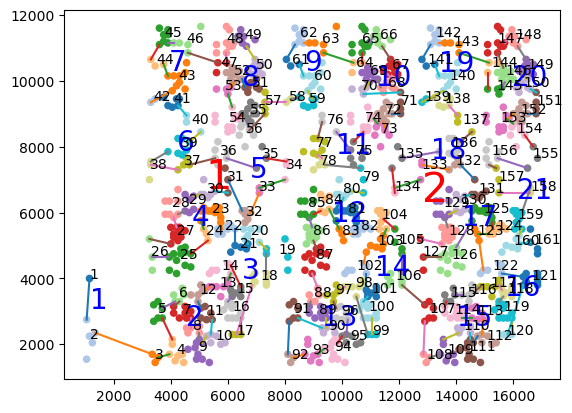

In [459]:
if True:
    route = np.array(route_btw_clusters)
    sol_route = np.array(sol_route)
    for n in range(int(len(route_btw_clusters)/2)-1):
        plt.plot(route[2*n+1:2*(n+1)+1,0], route[2*n+1:2*(n+1)+1,1], '-')
    plt.scatter(sol_route[:,0], sol_route[:,1], c=sys2_labels[n_hierarchies][:], s=20)

    colors = 'rbk'
    sol_route_ex = sol_route_ex[1:]
    for H in range(len(sol_route_ex)):
        for n in range(len(sol_route_ex[H])):
            plt.text(sol_route_ex[H][n][0],sol_route_ex[H][n][1], str(n+1), fontsize = 10*(len(sol_route_ex)-H), color = colors[H])
    plt.show()

In [460]:
from math import sin, cos, sqrt, atan2, radians
def compute_geo(p1,p2):
    R = 6373.0
    
    lat1 = radians(float(p1[0]))
    lon1 = radians(float(p1[1]))
    lat2 = radians(float(p2[0]))
    lon2 = radians(float(p2[1]))
    
    dlon = lon2 - lon1
    dlat = lat2 -lat1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    dist = R*c
    return dist

In [461]:
coord_geo == False
if coord_geo == True:
#     test = np.load("sys2clusters_" + str(x) + "/sol_table.npy", allow_pickle=True)
    for i in range(len(test)):
        print(i)
        for j in range(len(test[i])):
            geo_dist = 0
            li = test[i][j][1]
            for idx,elem in enumerate(li):
                thiscity = elem
                nextcity = li[(idx+1)%len(li)]
                geo_dist += compute_geo(thiscity, nextcity)
            test[i][j][2] = geo_dist 
            print(geo_dist)
        np.save("sys2clusters_" + str(x) + "/sol_table" ,test)    


mport pdb; pdb.set_trace()     

In [462]:
## Sangmin edited
GO = False
if GO:
    with open("tsp" + x + "_pyconcorde.txt", "w") as f:
        solver = TSPSolver.from_data(X_coord, Y_coord, norm="EUC_2D")  
        solution = solver.solve()
        f.write( str(" ") + str('output') + str(" ") )
        f.write( str("solution found? ") + str(solution.found_tour) + str(" ") )
        f.write( str("Optimal value? ") + str(solution.optimal_value) + str(" ") )
        f.write( str(" ").join( str(node_idx+1) for node_idx in solution.tour) )
        f.write( str(" ") + str(solution.tour[0]+1) + str(" ") )

In [463]:
GO = False
if GO:
    num_samples = 10000
    set_nodes_coord = np.random.random([num_samples, n_clusters, 2])
    with open("tsp" + str(n_clusters) + "_pr1002.txt", "w") as f:
        solver = TSPSolver.from_data(centers[:,0], centers[:,1], norm="EUC_2D")  
        solution = solver.solve()
        f.write( " ".join( str(x)+str(" ")+str(y) for x,y in centers) )
        f.write( str(" ") + str('output') + str(" ") )
        f.write( str(" ").join( str(node_idx+1) for node_idx in solution.tour) )
        f.write( str(" ") + str(solution.tour[0]+1) + str(" ") )
        